In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph, complete_graph

import scipy.stats as stats
from scipy.optimize import curve_fit

import numpy as np

import matplotlib.pyplot as plt

In [2]:
@py_random_state(2)
def barabasi_albert(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

## Distribuzione dei gradi

Random Graph

In [44]:
N = 1e4
P = 0.25

G_r = nx.erdos_renyi_graph(N, P)
while min([d for n, d in G_r.degree()]) == 0:
          G_r = nx.erdos_renyi_graph(N, P)

k = np.arange(min([d for n,d in G_r.degree]), max([d for n,d in G_r.degree])+1)
p = [0]*len(k)

k_mean =sum(k)/len(k)
for i in range(len(k)):
    for n,d in G_r.degree:
        if k[i] == d:
            p[i] += 1

norm = sum(p)                        
for i in range(len(p)):
    p[i] = p[i]/norm

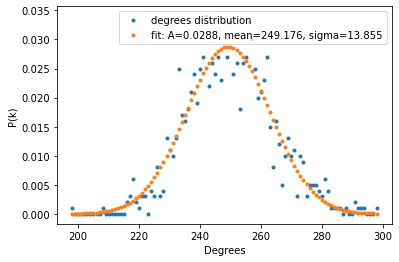

 - Data mean: 248.0
 - Mean from gaussian fit: 249.17555525236102 +/- 13.854827963246102


In [46]:
def gaus_law(x, a, mu=0, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

poptGaus, pcovGaus = curve_fit(gaus_law, k, p, 
                               p0 = [1,k_mean, 1])

fit_function = gaus_law(k, *poptGaus)

fig, ax = plt.subplots()

ax.plot(k, p, '.', label = 'degrees distribution')
ax.plot(k, fit_function, '.',
        label = f"fit: A={round(poptGaus[0],4)}, mean={round(poptGaus[1],3)}, sigma={round(poptGaus[2],3)}")

ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")      
ax.legend()

plt.show()

print(" - Data mean:", k_mean)
print(" - Mean from gaussian fit:", poptGaus[1], '+/-', poptGaus[2])

# stats.chisquare(p,fit_function, axis=None)

Scale-free

In [14]:
N = 1e4
M = 4

G_s = barabasi_albert(N, M)

k = np.arange(min([d for n,d in G_s.degree]), max([d for n,d in G_s.degree])+1)
p = [0]*len(k)

k_mean = sum(k)/len(k)
for i in range(len(k)):
    for n, d in G_s.degree:
        if k[i] == d:
            p[i] += 1

norm = sum(p)                        
for i in range(len(p)):
    p[i] = p[i]/norm

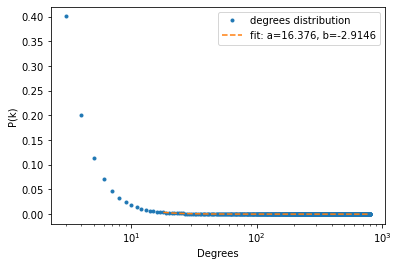

In [33]:
def power_law(x, a, b):
    return a*np.power(x, b)

x_low = 15
poptPower, pcovPower = curve_fit(power_law, k[x_low:], p[x_low:]) 

fit_function = power_law(k[x_low:], *poptPower)

fig, ax = plt.subplots()

ax.plot(k, p, '.', label = 'degrees distribution')
ax.plot(k[x_low:], fit_function, '--',
        label = f"fit: a={round(poptPower[0],3)}, b={round(poptPower[1],4)}")

ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")
ax.xaxis
ax.legend()

plt.xscale('log')
# plt.yscale('log')

plt.show()